# LLM RAG Generate Summary and Knowledge Graph

In [3]:
from langchain.document_loaders import PyMuPDFLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma

def extract_text_from_pdf(pdf_path):
    loader = PyMuPDFLoader(pdf_path)
    documents = loader.load()
    return documents

def split_text_into_chunks(documents, chunk_size=2000, chunk_overlap=200):
    text_splitter = CharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    chunks = text_splitter.split_documents(documents)
    return chunks

pdf_path = "pdf_files/agent-ai.pdf"  # Replace with your PDF file path
extracted_text = extract_text_from_pdf(pdf_path)
print(extracted_text)

chunks = split_text_into_chunks(extracted_text)





[Document(metadata={'producer': 'pdfTeX-1.40.25', 'creator': 'LaTeX with hyperref', 'creationdate': '2024-05-21T00:56:19+00:00', 'source': 'pdf_files/agent-ai.pdf', 'file_path': 'pdf_files/agent-ai.pdf', 'total_pages': 28, 'format': 'PDF 1.5', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'moddate': '2024-05-21T00:56:19+00:00', 'trapped': '', 'page': 0}, page_content='Work in Progress\n(PERHAPS) BEYOND HUMAN TRANSLATION:\nHAR-\nNESSING\nMULTI-AGENT\nCOLLABORATION\nFOR\nTRANSLATING ULTRA-LONG LITERARY TEXTS\nMinghao Wu1, Yulin Yuan2, Gholamreza Haffari1, Longyue Wang3∗\n1Monash University\n2University of Macau\n3Tencent AI Lab\nABSTRACT\nRecent advancements in machine translation (MT) have significantly enhanced\ntranslation quality across various domains. However, the translation of literary\ntexts remains a formidable challenge due to their complex language, figurative ex-\npressions, and cultural nuances. In this work, we introduce a novel multi-agent\nframework based on 

In [8]:
len(chunks)

28

In [9]:
len(chunks[0].page_content)

1996

# Check text chunks 

In [2]:
print(chunks[2].page_content)

2
Mixture-of-Agents Methodology
In this section, we present our proposed methodology for leveraging multiple models to achieve
boosted performance. We begin by demonstrating that LLMs possess collaborativeness and thus
can improve their responses based on the outputs of other models. Following this, we introduce the
Mixture-of-Agents methodology and discuss its design implications.
2.1
Collaborativeness of LLMs
We begin by demonstrating the collaborativeness of LLMs, specifically their ability to generate higher
quality responses when they can reference outputs from other models. As we have shown in the
introduction and Figure 1, many of today’s available LLMs exhibit this collaborative capability.
An important pathway to extract maximum benefits from collaboration of multiple LLMs is to
characterize how different models are good at in various aspects of collaboration. During the
collaboration process, we can categorize LLMs into two distinct roles:
Proposers excel at generating useful

# Save to Local Vector DB

In [3]:
embedding = OpenAIEmbeddings(model="text-embedding-3-small")
db = Chroma.from_documents(chunks, embedding,persist_directory="pdf_db")

In [4]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-4o-mini")
model.invoke("Hello World")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 9, 'total_tokens': 19, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_00428b782a', 'finish_reason': 'stop', 'logprobs': None}, id='run-7a6fb554-5b7b-4a68-83fd-0302e471a341-0', usage_metadata={'input_tokens': 9, 'output_tokens': 10, 'total_tokens': 19, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

# Sample Knowledge Graph 

# 

In [10]:
from itertools import combinations
import networkx as nx
import matplotlib.pyplot as plt
from openai import OpenAI
import json 

def create_json_from_text(text):
  prompt = f"""
  Extract named entities and their relationships from the following text. 
  Format the output as a JSON object with two keys: 
  - "entities": a list of unique entity names
  - "relations": a list of relationships, where each item is an object with:
    - "source" (the first entity)
    - "target" (the second entity)
    - "relation" (the type of relationship)

  Text:
  {text[:4000]}  # จำกัดไม่เกิน 4,000 ตัวอักษร (GPT-4o-mini รับ input ได้ประมาณนี้)

  Output should be in JSON format:
  """

  client = OpenAI()
  response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[{"role": "system", "content": "You are an AI that extracts structured knowledge from text."},
              {"role": "user", "content": prompt}]
  )

  output_json = response.choices[0].message.content
  clean_json_text = output_json.strip("```json").strip("```").strip()
  data = json.loads(clean_json_text)
  return data 


# Summary Each Chunk

In [43]:
data = create_json_from_text(chunks[2].page_content)

{'entities': ['Elon Musk', 'Tesla', 'SpaceX', 'California', 'Florida', 'NASA'],
 'relations': [{'source': 'Elon Musk', 'target': 'Tesla', 'relation': 'CEO'},
  {'source': 'Elon Musk', 'target': 'SpaceX', 'relation': 'CEO'},
  {'source': 'Tesla', 'target': 'California', 'relation': 'headquartered in'},
  {'source': 'SpaceX',
   'target': 'Florida',
   'relation': 'launched a rocket from'},
  {'source': 'NASA', 'target': 'SpaceX', 'relation': 'collaborates with'}]}

In [4]:
from langchain_openai import ChatOpenAI


model = ChatOpenAI(model="gpt-4o-mini")
def summarize_chunks(chunks) -> list[str]:
  summary_list = []
  for chunk in chunks:
    prompt_summary = f"Summarize the following text: {chunk.page_content}"
    summary = model.invoke(prompt_summary)
    summary_list.append(summary.content)
  return summary_list

summary_list = summarize_chunks(chunks)

In [7]:
summary_list = [summary.content for summary in summary_list]
summary_list

['The paper by Junlin Wang et al. presents a novel approach called Mixture-of-Agents (MoA) to enhance the capabilities of large language models (LLMs). Recognizing the diverse strengths of various LLMs in natural language understanding and generation, the authors propose a layered architecture where multiple LLM agents collaborate, utilizing outputs from previous layers as auxiliary information to improve their responses. The MoA methodology demonstrates state-of-the-art performance on benchmarks like AlpacaEval 2.0, MT-Bench, and FLASK, outperforming even advanced models like GPT-4 Omni. The research emphasizes the potential of leveraging the collective expertise of multiple LLMs to overcome individual model limitations without the need for extensive retraining or scaling.',
 "The text discusses the Mixture-of-Agents (MoA) methodology, which enhances the response quality of large language models (LLMs) through collaboration. The MoA structure consists of multiple layers of agents that

In [8]:
# convert summary_list to string
summary_string = "\n".join(summary_list)
print(summary_string)

The paper by Junlin Wang et al. presents a novel approach called Mixture-of-Agents (MoA) to enhance the capabilities of large language models (LLMs). Recognizing the diverse strengths of various LLMs in natural language understanding and generation, the authors propose a layered architecture where multiple LLM agents collaborate, utilizing outputs from previous layers as auxiliary information to improve their responses. The MoA methodology demonstrates state-of-the-art performance on benchmarks like AlpacaEval 2.0, MT-Bench, and FLASK, outperforming even advanced models like GPT-4 Omni. The research emphasizes the potential of leveraging the collective expertise of multiple LLMs to overcome individual model limitations without the need for extensive retraining or scaling.
The text discusses the Mixture-of-Agents (MoA) methodology, which enhances the response quality of large language models (LLMs) through collaboration. The MoA structure consists of multiple layers of agents that indep

In [11]:
data_json = create_json_from_text(summary_string)
data_json

{'entities': ['Junlin Wang',
  'Mixture-of-Agents (MoA)',
  'large language models (LLMs)',
  'AlpacaEval 2.0',
  'MT-Bench',
  'FLASK',
  'GPT-4 Omni',
  'Proposers',
  'Aggregators',
  'Mixture-of-Experts (MoE)',
  'GPT-4 Turbo',
  'GPT-4o'],
 'relations': [{'source': 'Junlin Wang',
   'target': 'Mixture-of-Agents (MoA)',
   'relation': 'authored'},
  {'source': 'Mixture-of-Agents (MoA)',
   'target': 'large language models (LLMs)',
   'relation': 'enhances'},
  {'source': 'Mixture-of-Agents (MoA)',
   'target': 'AlpacaEval 2.0',
   'relation': 'benchmarked on'},
  {'source': 'Mixture-of-Agents (MoA)',
   'target': 'MT-Bench',
   'relation': 'benchmarked on'},
  {'source': 'Mixture-of-Agents (MoA)',
   'target': 'FLASK',
   'relation': 'benchmarked on'},
  {'source': 'Mixture-of-Agents (MoA)',
   'target': 'GPT-4 Omni',
   'relation': 'outperforms'},
  {'source': 'Proposers',
   'target': 'Aggregators',
   'relation': 'collaborates with'},
  {'source': 'Mixture-of-Agents (MoA)',
   '

# Create Knowledge Graph and visualize it

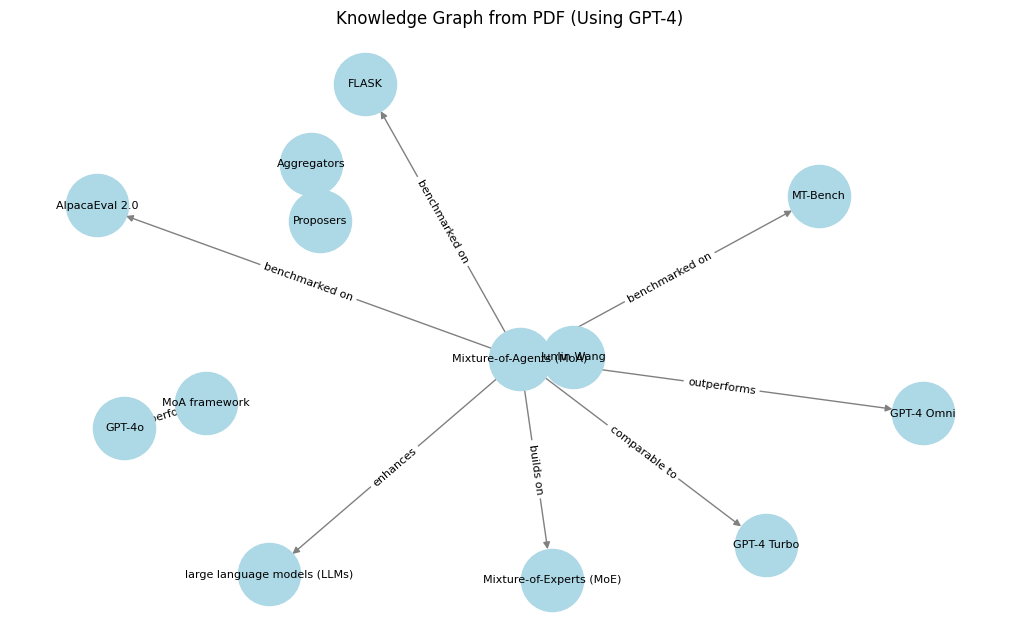

In [17]:
def create_knowledge_graph(data):
    # สร้าง Knowledge Graph ด้วย NetworkX
    G = nx.DiGraph()

    # เพิ่ม Nodes (Entity)
    for entity in data["entities"]:
        G.add_node(entity)

    # เพิ่ม Relationships (Edges)
    for relation in data["relations"]:
        G.add_edge(relation["source"], relation["target"], label=relation["relation"])

        # วาดกราฟ
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=2000, font_size=8)

    # แสดงชื่อความสัมพันธ์บนเส้นเชื่อม
    edge_labels = {(rel["source"], rel["target"]): rel["relation"] for rel in data["relations"]}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    plt.savefig("knowledge_graph.png", format="png")

    # plt.title("Knowledge Graph from PDF (Using GPT-4)")
    # plt.show()

create_knowledge_graph(data_json)

In [20]:
print(summary_string)

The paper by Junlin Wang et al. presents a novel approach called Mixture-of-Agents (MoA) to enhance the capabilities of large language models (LLMs). Recognizing the diverse strengths of various LLMs in natural language understanding and generation, the authors propose a layered architecture where multiple LLM agents collaborate, utilizing outputs from previous layers as auxiliary information to improve their responses. The MoA methodology demonstrates state-of-the-art performance on benchmarks like AlpacaEval 2.0, MT-Bench, and FLASK, outperforming even advanced models like GPT-4 Omni. The research emphasizes the potential of leveraging the collective expertise of multiple LLMs to overcome individual model limitations without the need for extensive retraining or scaling.
The text discusses the Mixture-of-Agents (MoA) methodology, which enhances the response quality of large language models (LLMs) through collaboration. The MoA structure consists of multiple layers of agents that indep

In [5]:
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_text_splitters import CharacterTextSplitter
from langchain_core.documents import Document
from langchain_openai import ChatOpenAI
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate
from openai import OpenAI
import json
import networkx as nx
import matplotlib.pyplot as plt



def extract_text_from_pdf(pdf_path):
    loader = PyMuPDFLoader(pdf_path)
    documents = loader.load()
    return documents

def split_text_into_chunks(documents, chunk_size=1000, chunk_overlap=200) -> list[Document]:
    text_splitter = CharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    chunks = text_splitter.split_documents(documents)
    return chunks

def summaize_text(docs,model):
  prompt = ChatPromptTemplate.from_messages(
    [("system", "Write a concise summary of the following:\\n\\n{context}")]
  )
  chain = create_stuff_documents_chain(model, prompt)
  result = chain.invoke({"context": docs})
  return result 


def summarize_chunks(chunks,model) -> list[str]:
  summary_list = []
  for chunk in chunks:
    prompt_summary = f"Summarize the following text: {chunk.page_content}"
    summary = model.invoke(prompt_summary)
    summary_list.append(summary.content)
  return summary_list

def create_json_from_text(text):
  prompt = f"""
  Extract named entities and their relationships from the following text. 
  Format the output as a JSON object with two keys: 
  - "entities": a list of unique entity names
  - "relations": a list of relationships, where each item is an object with:
    - "source" (the first entity)
    - "target" (the second entity)
    - "relation" (the type of relationship)

  Text:
  {text[:4000]}  # จำกัดไม่เกิน 4,000 ตัวอักษร (GPT-4o-mini รับ input ได้ประมาณนี้)

  Output should be in JSON format:
  """

  client = OpenAI()
  response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[{"role": "system", "content": "You are an AI that extracts structured knowledge from text."},
              {"role": "user", "content": prompt}]
  )

  output_json = response.choices[0].message.content
  clean_json_text = output_json.strip("```json").strip("```").strip()
  data = json.loads(clean_json_text)
  return data
  
def create_knowledge_graph(data):
    # สร้าง Knowledge Graph ด้วย NetworkX
    G = nx.DiGraph()

    # เพิ่ม Nodes (Entity)
    for entity in data["entities"]:
        G.add_node(entity)

    # เพิ่ม Relationships (Edges)
    for relation in data["relations"]:
        G.add_edge(relation["source"], relation["target"], label=relation["relation"])

        # วาดกราฟ
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=2000, font_size=8)

    # แสดงชื่อความสัมพันธ์บนเส้นเชื่อม
    edge_labels = {(rel["source"], rel["target"]): rel["relation"] for rel in data["relations"]}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    # plt.title("Knowledge Graph from PDF (Using GPT-4o-mini)")
    plt.savefig("knowledge_graph.png", format="png")
    print("Knowledge Graph saved as knowledge_graph.png")

# Summarize Chain

https://python.langchain.com/docs/tutorials/summarization/ => ตัวอย่างการใช้งาน summarize by stuff docs and map reduce 


In [4]:
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains.llm import LLMChain
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI


llm = ChatOpenAI(model="gpt-4o-mini")
docs = extract_text_from_pdf("pdf_files/agent-ai.pdf")          

# Define prompt
prompt = ChatPromptTemplate.from_messages(
    [("system", "Write a concise summary of the following:\\n\\n{context}")]
)

# Instantiate chain
chain = create_stuff_documents_chain(llm, prompt)

# Invoke chain
result = chain.invoke({"context": docs})
print(result)


The paper presents a novel multi-agent system for literary translation called TRANSAGENTS, developed by researchers from Monash University, the University of Macau, and Tencent AI Lab. This system leverages large language models (LLMs) to enhance translation quality for ultra-long literary texts, which often pose significant challenges due to their complex language, cultural nuances, and figurative expressions. 

The proposed framework mimics traditional translation processes by utilizing a team of agents, each fulfilling specific roles (e.g., Senior Editor, Translator, Localization Specialist, Proofreader) and cooperating through collaborative strategies. To evaluate the effectiveness of the translations produced, the authors introduce two innovative evaluation methods: Monolingual Human Preference (MHP) and Bilingual LLM Preference (BLP), which measure how well translations resonate with target audiences and how they compare to original texts, respectively. 

Despite achieving lower 

Knowledge Graph saved as knowledge_graph.png


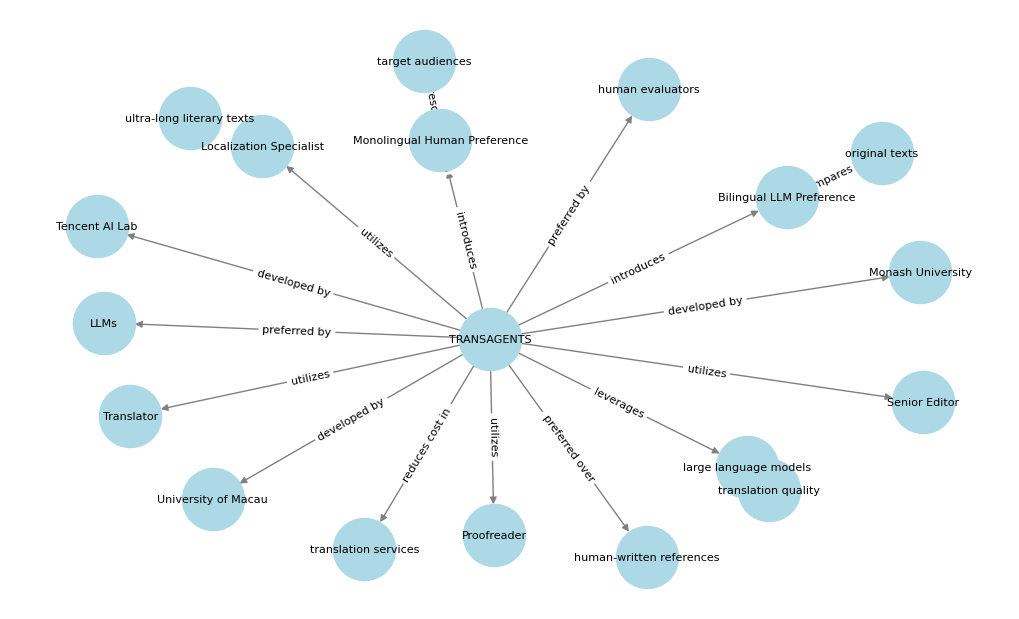

In [6]:
summarize_text = result 
json_data = create_json_from_text(summarize_text)
create_knowledge_graph(json_data)


# RAG 

In [2]:
# RAG 
extracted_text = extract_text_from_pdf("pdf_files/agent-ai.pdf")
chunks = split_text_into_chunks(extracted_text)







NameError: name 'extract_text_from_pdf' is not defined